### Dependencies

In [ ]:
!pip install cmake face_recognition numpy opencv-python

In [ ]:
!pip install mtcnn

In [ ]:
import face_recognition
import cv2
import numpy as np
import os
import glob
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import random
import math

In [ ]:
from mtcnn import MTCNN
detector = MTCNN()

###  Registration and Training

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
faces_encodings = []
faces_names = []
cur_direc = "/content/drive/MyDrive/"
print(cur_direc)
path = os.path.join(cur_direc, 'training/')
#print(path)
list_of_files = [f for f in glob.glob(path+'*.jpg')]
number_files = len(list_of_files)
names = list_of_files.copy()

/content/drive/MyDrive/


In [ ]:
for i in range(number_files):
    globals()['image_{}'.format(i)] = face_recognition.load_image_file(list_of_files[i])
    globals()['image_encoding_{}'.format(i)] = face_recognition.face_encodings(globals()['image_{}'.format(i)])[0]
    faces_encodings.append(globals()['image_encoding_{}'.format(i)])
# Create array of known names
    names[i] = names[i].replace(cur_direc, "")  
    faces_names.append(names[i])

In [ ]:
names

['training/Preksha.jpg']

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
def check_right(righteye,lefteye,nose,orig_eye_dist,orig_nose_x):
    dist = math.sqrt((righteye[0]-lefteye[0])**2 + (righteye[1]-lefteye[1])**2)
    if dist<=orig_eye_dist*0.9 and nose[0]<orig_nose_x:
        return True
    else:
        return False
    
def check_left(righteye,lefteye,nose,orig_eye_dist,orig_nose_x):
    dist = math.sqrt((righteye[0]-lefteye[0])**2 + (righteye[1]-lefteye[1])**2)
    if dist<=orig_eye_dist*0.9 and nose[0]>orig_nose_x:
        return True
    else:
        return False
    

In [ ]:

def real_time_tests(name):
    tasks = ['Right','Left']
    tasks = random.sample(tasks, 2)
    print(tasks)
    font = cv2.FONT_HERSHEY_SIMPLEX
    count,tasks_completed,out = 0,0,0
    status = False
    cam = take_photo()

    while True:
        # image extraction from android phone camera using IP Webcam
        image = cv2.imread(cam)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        result = detector.detect_faces(image)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)


        if len(result) != 0:
            bounding_box = result[0]['box']
            keypoints = result[0]['keypoints']
            cv2.rectangle(image,(bounding_box[0], bounding_box[1]),(bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),(0,155,255),2)
            cv2.circle(image,(keypoints['left_eye']), 2, (0,155,255), 2)
            cv2.circle(image,(keypoints['right_eye']), 2, (0,155,255), 2)
            cv2.circle(image,(keypoints['nose']), 2, (0,155,255), 2)
            cv2.circle(image,(keypoints['mouth_left']), 2, (0,155,255), 2)
            cv2.circle(image,(keypoints['mouth_right']), 2, (0,155,255), 2)

            # Storing Defaults
            if count==0:
                original_eye_dist = math.sqrt((keypoints['right_eye'][0]-keypoints['left_eye'][0])**2 + (keypoints['right_eye'][1]-keypoints['left_eye'][1])**2)
                #print("Original Eye Distance = ",original_eye_dist)
                original_mouth_dist = math.sqrt((keypoints['mouth_right'][0]-keypoints['mouth_left'][0])**2 + (keypoints['mouth_right'][1]-keypoints['mouth_left'][1])**2)
                #print("Original Lip Distance = ",original_mouth_dist)
                original_nose_x = keypoints['nose'][0]
                count+=1
                #continue

            task = tasks[0]
            image = cv2.resize(image,(800,800))
            image = cv2.putText(image, task, (350,25), font,0.75, (255,255,255), 2)
            cv2_imshow(image)
            if task == 'Right':
                status = check_right(keypoints['right_eye'],keypoints['left_eye'],keypoints['nose'],original_eye_dist,original_nose_x)
            elif task == 'Left':
                status = check_left(keypoints['right_eye'],keypoints['left_eye'],keypoints['nose'],original_eye_dist,original_nose_x)
            #print(status)
            tasks_completed += 1
            tasks = tasks[1:]
            count +=1
        else:
            out+=1
          #continue
        if tasks_completed == 2 or out>2 :
           break 
        #cam.release()
    cv2.destroyAllWindows()

    if tasks_completed == 2:
        print("Liveness Testing Complete!")
        print(name + " Access Granted")
    else:
        print("Use of image is prohibited for identification.")
    #print(out)

In [ ]:
def recognize_face(frame):
    distance=0
    face_locations = []
    face_encodings = []
    face_names = []
    process_this_frame = True
    small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25) #resize the frame 
    rgb_small_frame = small_frame[:, :, ::-1]
    if process_this_frame:
        face_locations = face_recognition.face_locations(rgb_small_frame) #localize the faces, rgb image is passed as agrument.
        #print(face_locations)
        face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations) # face_encoding codes face into vector 
        #print(face_encodings)
        face_names = []
        for face_encoding in face_encodings:
            matches = face_recognition.compare_faces(faces_encodings, face_encoding) # compare_faces function is computing the Euclidean distance between the candidate embedding and all faces in our dataset
            name = "Unknown" 
            
            face_distances = face_recognition.face_distance(faces_encodings, face_encoding) # face_distance calculates distance of person from webcam
            
            best_match_index = np.argmin(face_distances)
            distance=face_distances[best_match_index]
            print(face_distances[best_match_index])
            if distance<0.5: # here, i have taken distance < 0.5 to get more accurate result in order to eliminate false positive 
              if matches[best_match_index]:
                  name = faces_names[best_match_index]
                  return name
              else:
                    return None
            face_names.append(name)
    process_this_frame = not process_this_frame
    # Display the results
    for (top, right, bottom, left), name in zip(face_locations, face_names):
          top *= 4
          right *= 4
          bottom *= 4
          left *= 4
    # Draw a rectangle around the face
          cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)
    # Input text label with a name below the face
          cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
          font = cv2.FONT_HERSHEY_DUPLEX
          cv2.putText(frame, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)
    # Display the resulting image
    #cv2_imshow(frame)


In [ ]:
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/haarcascade_frontalface_default.xml') #load face cascade in memory

In [ ]:
def recognize_faces_in_cam_50():

    count=0
    confirmation = 0
    name = ''
    
    cam = take_photo()
    while count<=5 and confirmation < 2:
        frame = cv2.imread(cam)
        img = frame
        height, width, channels = frame.shape

        
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        # Loop through all the faces detected 
        identities = ''
        if len(faces)!=0:
            for (x, y, w, h) in faces:
                x1 = x
                y1 = y
                x2 = x+w
                y2 = y+h



                face_image = frame[max(0, y1):min(height, y2), max(0, x1):min(width, x2)]    
                identity = recognize_face(face_image)
                print(identity)

                if identity is not None:
                    confirmation+=1
                    
                    name = identity
            count+=1
        else:
            print("Please be infront of the camera")
    print(confirmation)
    #cam.release()
    cv2.destroyAllWindows()

    
    if confirmation == 2:
        print("Face Verification Complete!")
        print("Testing For Liveness....")
        real_time_tests(name)
    else:
        print("Use of image is prohibited for identification.")

In [ ]:
def store_sample(name):
    
    face_detector = cv2.CascadeClassifier('/content/drive/MyDrive/haarcascade_frontalface_default.xml')
    count = 0
    
    cam = take_photo() #cv2.VideoCapture(0)
    while(True):
      _=True
      img = cv2.imread(cam)

        #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      faces = face_detector.detectMultiScale(img, 1.3, 5)
      for (x,y,w,h) in faces:
          x1 = x
          y1 = y
          x2 = x+w
          y2 = y+h
          cv2.rectangle(img, (x1,y1), (x2,y2), (255,255,255), 2)     
          count += 1
          # Save the captured image into the datasets folder
          if count==10:
              cv2.imwrite("/content/drive/MyDrive/training/" + name + ".jpg", img[y1:y2,x1:x2])
          #cv2_imshow('image', img)
      
      if cv2.waitKey(1) == 27 or count >= 10:
          break
  #cam.release()
cv2.destroyAllWindows()

### Prediction or Facial Detection and Identification

Are you a Registered User: yes
Would you like to open the device: yes
Face Verification in process....


<IPython.core.display.Javascript object>

0.3676656838870225
training/Preksha.jpg
0.3676656838870225
training/Preksha.jpg
2
Face Verification Complete!
Testing For Liveness....
['Left', 'Right']


<IPython.core.display.Javascript object>

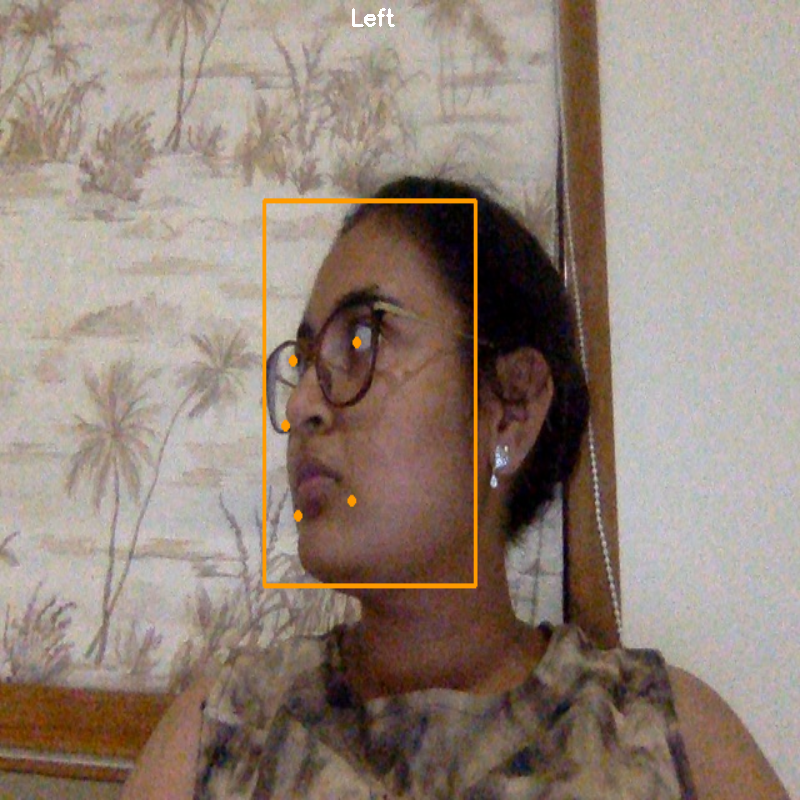

False


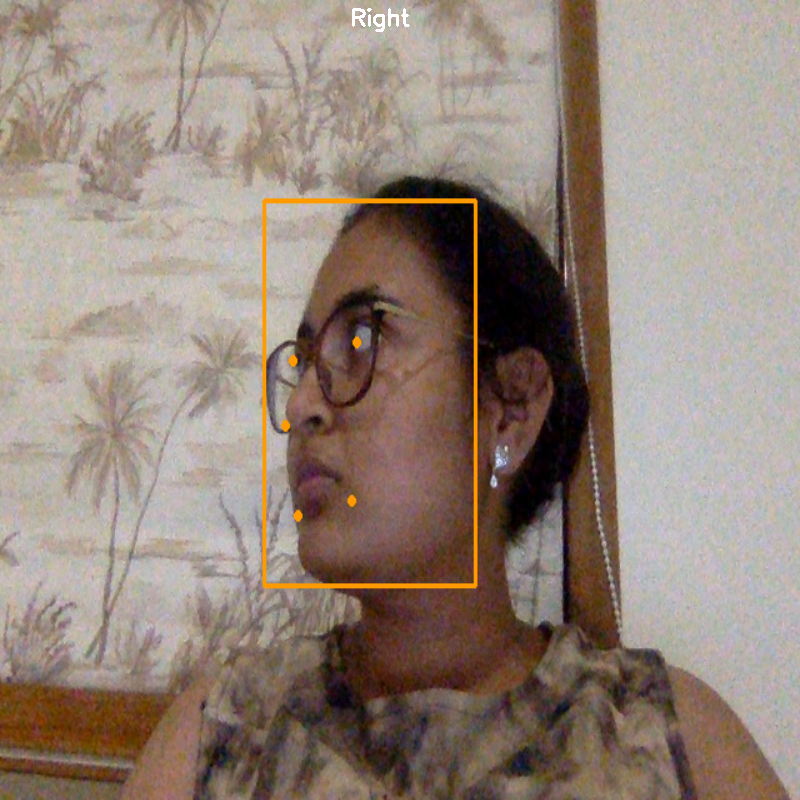

False
Liveness Testing Complete!
training/Preksha.jpg Access Granted


In [ ]:
choice = input("Are you a Registered User: ")
if choice == "no":
    name = input("Enter your Name and be ready infront of camera: ")
    store_sample(name)
    print("Registration Successful")
ch = input("Would you like to open the device: ")
if ch == 'yes':
    print("Face Verification in process....")
    recognize_faces_in_cam_50()     

In [ ]:
choice = input("Are you a Registered User: ")
if choice == "no":
    name = input("Enter your Name and be ready infront of camera: ")
    store_sample(name)
    print("Registration Successful")
ch = input("Would you like to open the device: ")
if ch == 'yes':
    print("Face Verification in process....")
    recognize_faces_in_cam_50()     

Are you a Registered User: yes
Would you like to open the device: yes
Face Verification in process....


<IPython.core.display.Javascript object>

0.6109603738175211
None
0.6109603738175211
None
0.6109603738175211
None
0.6109603738175211
None
0.6109603738175211
None
0.6109603738175211
None
0
Use of image is prohibited for identification.


Are you a Registered User: yes
Would you like to open the device: yes
Face Verification in process....


<IPython.core.display.Javascript object>

0.4491915182402486
training/Preksha.jpg
0.4491915182402486
training/Preksha.jpg
2
Face Verification Complete!
Testing For Liveness....
['Right', 'Left']


<IPython.core.display.Javascript object>

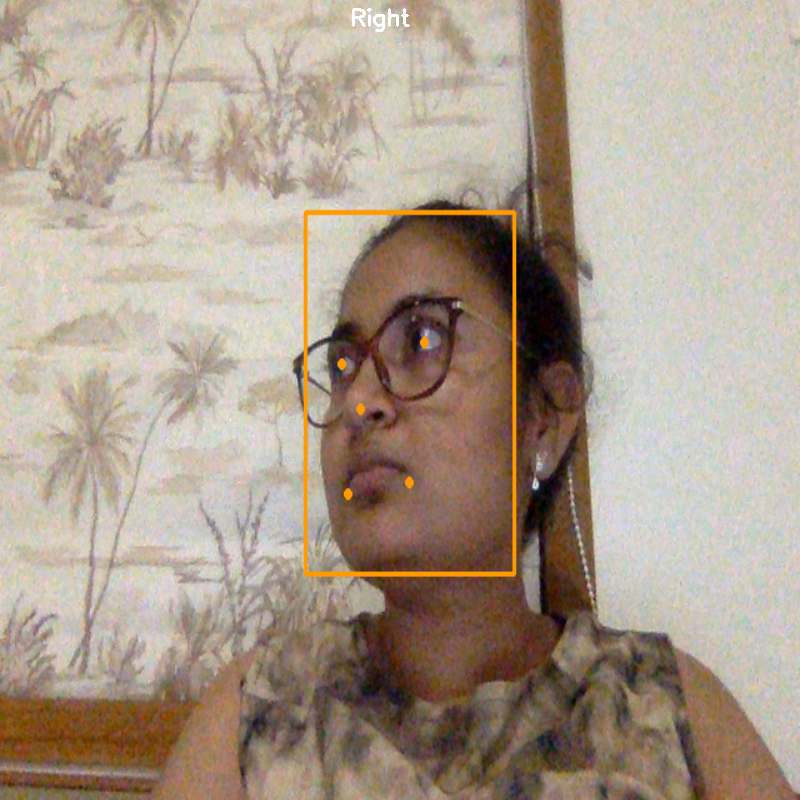

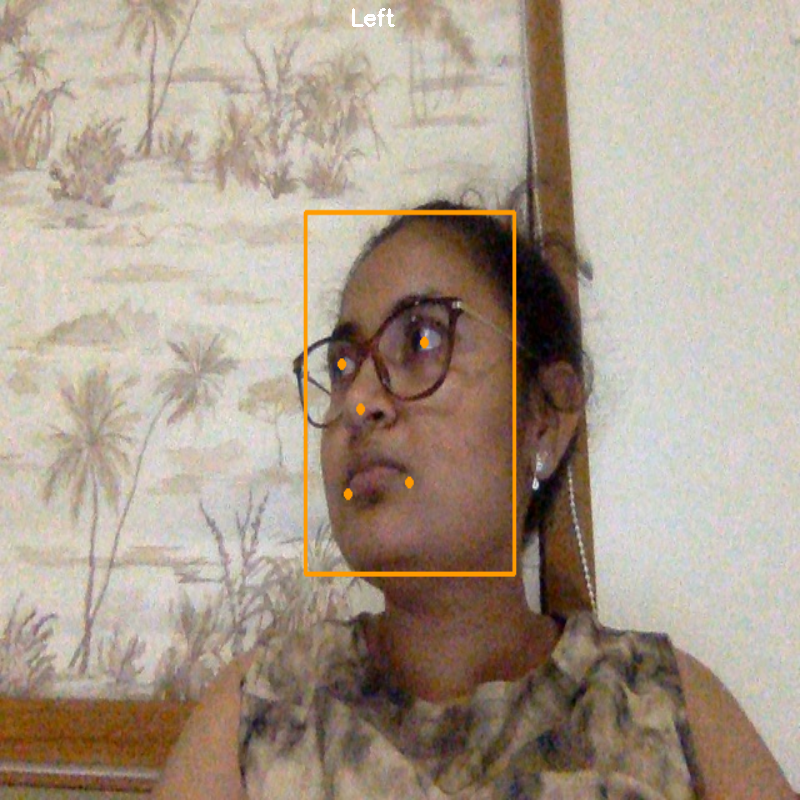

Liveness Testing Complete!
training/Preksha.jpg Access Granted


In [ ]:
choice = input("Are you a Registered User: ")
if choice == "no":
    name = input("Enter your Name and be ready infront of camera: ")
    store_sample(name)
    print("Registration Successful")
ch = input("Would you like to open the device: ")
if ch == 'yes':
    print("Face Verification in process....")
    recognize_faces_in_cam_50()     